📊 Loading data...
✅ Data loaded and cleaned!

Building network graph...
   Network: 1295 nodes, 1305 edges

Creating network structure analysis...
Calculating centrality metrics...
✅ Saved: 02_network_structure.png

📊 Network Statistics:
   Nodes: 1295
   Edges: 1305
   Avg Degree: 2.02
   Network Density: 0.0016
   Connected Components: 2

✅ Part 2 Complete! Run part 3 next for temporal analysis.


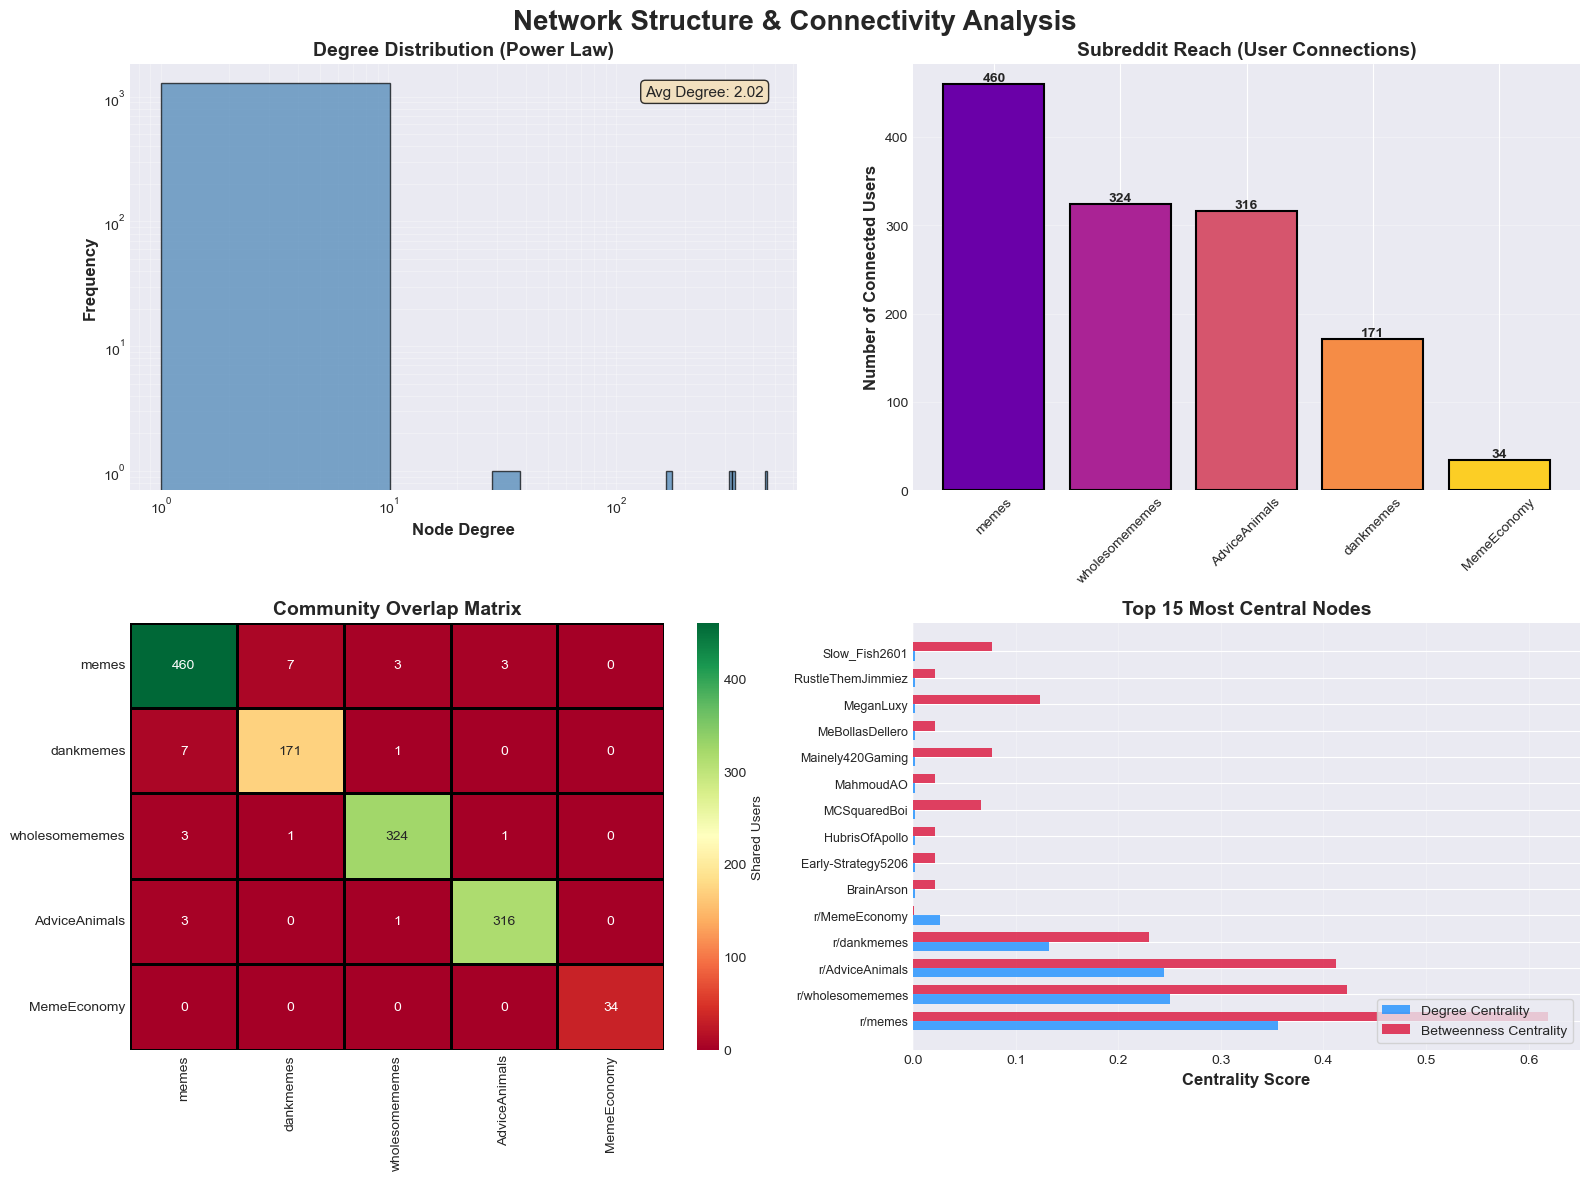

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import numpy as np
import warnings
warnings.filterwarnings('ignore')

"""
PART 2: NETWORK STRUCTURE ANALYSIS
----------------------------------
Analyzes network topology, centrality, and community overlap
"""

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("📊 Loading data...")
df_detailed = pd.read_csv('reddit_interactions_detailed.csv')
df_edges = pd.read_csv('reddit_meme_network_edges.csv')

# Clean data thoroughly
df_detailed = df_detailed.dropna(subset=['user'])
df_detailed = df_detailed[df_detailed['user'] != 'None']
df_detailed['user'] = df_detailed['user'].astype(str)

df_edges = df_edges.dropna(subset=['user', 'target_subreddit'])
df_edges = df_edges[df_edges['user'] != 'None']
df_edges['user'] = df_edges['user'].astype(str)
df_edges['target_subreddit'] = df_edges['target_subreddit'].astype(str)

print("✅ Data loaded and cleaned!\n")

# Build network
print("Building network graph...")
G = nx.Graph()
for _, row in df_edges.iterrows():
    G.add_edge(row['user'], row['target_subreddit'], weight=row['weight'])

subreddits = df_detailed['target_subreddit'].unique()
print(f"   Network: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges\n")

# ========================================
# FIGURE 2: NETWORK STRUCTURE (4 panels)
# ========================================
print("Creating network structure analysis...")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Network Structure & Connectivity Analysis', fontsize=20, fontweight='bold')

# Panel 1: Degree Distribution
ax = axes[0, 0]
degrees = [d for n, d in G.degree()]
ax.hist(degrees, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
ax.set_xlabel('Node Degree', fontsize=12, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax.set_title('Degree Distribution (Power Law)', fontsize=14, fontweight='bold')
ax.set_yscale('log')
ax.set_xscale('log')
ax.grid(True, alpha=0.3, which='both')
ax.text(0.95, 0.95, f'Avg Degree: {np.mean(degrees):.2f}', 
        transform=ax.transAxes, ha='right', va='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8), fontsize=11)

# Panel 2: Subreddit Reach
ax = axes[0, 1]
subreddit_degrees = {}
for sub in subreddits:
    if sub in G:
        subreddit_degrees[sub] = G.degree(sub)

sorted_subs = sorted(subreddit_degrees.items(), key=lambda x: x[1], reverse=True)
sub_names = [s[0].replace('r/', '') for s in sorted_subs]
sub_degrees = [s[1] for s in sorted_subs]

colors = plt.cm.plasma(np.linspace(0.2, 0.9, len(sub_names)))
bars = ax.bar(sub_names, sub_degrees, color=colors, edgecolor='black', linewidth=1.5)
ax.set_ylabel('Number of Connected Users', fontsize=12, fontweight='bold')
ax.set_title('Subreddit Reach (User Connections)', fontsize=14, fontweight='bold')
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom', fontweight='bold', fontsize=10)

# Panel 3: Community Overlap Matrix
ax = axes[1, 0]
overlap_matrix = np.zeros((len(subreddits), len(subreddits)))
for i, sub1 in enumerate(subreddits):
    users1 = set(df_detailed[df_detailed['target_subreddit'] == sub1]['user'])
    for j, sub2 in enumerate(subreddits):
        users2 = set(df_detailed[df_detailed['target_subreddit'] == sub2]['user'])
        overlap_matrix[i, j] = len(users1.intersection(users2))

sub_labels = [s.replace('r/', '') for s in subreddits]
sns.heatmap(overlap_matrix, annot=True, fmt='.0f', cmap='RdYlGn', 
            xticklabels=sub_labels, yticklabels=sub_labels, ax=ax,
            cbar_kws={'label': 'Shared Users'}, linewidths=1, linecolor='black')
ax.set_title('Community Overlap Matrix', fontsize=14, fontweight='bold')

# Panel 4: Network Centrality Rankings (FIXED)
ax = axes[1, 1]
print("Calculating centrality metrics...")
degree_cent = nx.degree_centrality(G)
betweenness_cent = nx.betweenness_centrality(G)

# Get top nodes - filter out any NaN/None nodes
top_nodes = []
for node, cent in sorted(degree_cent.items(), key=lambda x: x[1], reverse=True):
    # Only include valid nodes
    if node is not None and isinstance(node, str) and node != 'None':
        top_nodes.append((node, cent))
    if len(top_nodes) >= 15:
        break

# Create labels - check if node is in subreddits
node_names = []
for node, _ in top_nodes:
    if node in subreddits:
        node_names.append(f"r/{node}"[:20])
    else:
        node_names.append(str(node)[:20])

degree_vals = [degree_cent[n[0]] for n in top_nodes]
between_vals = [betweenness_cent[n[0]] for n in top_nodes]

x = np.arange(len(node_names))
width = 0.35
bars1 = ax.barh(x - width/2, degree_vals, width, label='Degree Centrality', 
                color='dodgerblue', alpha=0.8)
bars2 = ax.barh(x + width/2, between_vals, width, label='Betweenness Centrality', 
                color='crimson', alpha=0.8)

ax.set_yticks(x)
ax.set_yticklabels(node_names, fontsize=9)
ax.set_xlabel('Centrality Score', fontsize=12, fontweight='bold')
ax.set_title('Top 15 Most Central Nodes', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', frameon=True, fancybox=True)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
# plt.savefig('02_network_structure.png', dpi=300, bbox_inches='tight')
# print("✅ Saved: 02_network_structure.png")

# ========================================
# NETWORK STATS
# ========================================
print("\n📊 Network Statistics:")
print(f"   Nodes: {G.number_of_nodes()}")
print(f"   Edges: {G.number_of_edges()}")
print(f"   Avg Degree: {np.mean(degrees):.2f}")
print(f"   Network Density: {nx.density(G):.4f}")
print(f"   Connected Components: {nx.number_connected_components(G)}")

print("\n✅ Part 2 Complete! Run part 3 next for temporal analysis.")